# Подготовительный этап

In [1]:
from google.colab import drive


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path_csv_test = "/content/drive/MyDrive/Data/under/data/intents_test.csv"
path_csv_train = "/content/drive/MyDrive/Data/under/data/intents_train.csv"
path_csv_train1 = "/content/drive/MyDrive/Data/under/data/intents_train1.csv"
path_csv_predict = "/content/drive/MyDrive/Data/under/data/intents_predict1.csv"
path_model = "/content/drive/MyDrive/Data/under/data/model.pkl"
path_table = "/content/drive/MyDrive/Data/under/data/table.csv"

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import SimpleRNN, Embedding, LSTM, Bidirectional, Conv2D, MaxPool2D, Flatten, Reshape
from keras.layers.core import Dense, Dropout, Activation

# Проверяем баланс данных

In [ ]:
train_df1 = pd.read_csv(path_csv_train1, sep=',')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Bike Types'),
 Text(0, 0, 'Cost Estimation'),
 Text(0, 0, 'Hours'),
 Text(0, 0, 'Make Appointment'),
 Text(0, 0, 'Return Policy'),
 Text(0, 0, 'Trade-in Options'),
 Text(0, 0, 'Welcome Intent')]

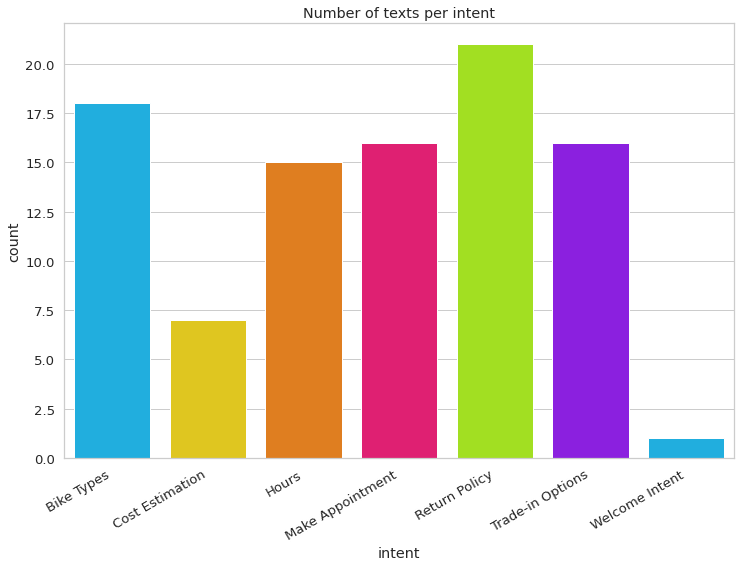

In [ ]:
chart = sns.countplot(train_df1.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right')

# Готовим данные для обучения

In [ ]:
train_df = pd.read_csv(path_csv_train, sep=',')
train_df[:3]

,text,intent
0,Carbon fiber bike,Bike Types
1,budget bikes,Bike Types
2,professional bikes,Bike Types


In [ ]:
ss = set(train_df['intent'].to_list())
box = {}
i = 0
for s in ss:
    if s not in box:
        box[s] = i
        i+=1

In [ ]:
def job1(strin):
  return box[strin]

In [ ]:
train_df['intent'] = train_df['intent'].apply(job1)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(train_df[['text']], train_df['intent'], test_size=0.25, random_state=20)

In [ ]:
full_text = [i.lower() for i in list(train_df['text'].values)]
# full_text_test = [i.lower() for i in list(X_test['text'].values) if i not in ['.',',','/','@','"','&amp','<br />','+/-','zzzzzzzzzzzzzzzzz',':-D',':D',':P',':)','!',';']]

In [ ]:
training_labels_final = np.array(train_df['intent'].values)
# testing_labels_final = np.array(y_test.values)

# Токенизация и паддинг

In [ ]:
embedding_dim=64
trunc_type= 'post'
oov_tok="<OOV>"

In [ ]:
tokenizer = Tokenizer(oov_token=oov_tok, lower = True, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(full_text)
word_index = tokenizer.word_index

In [ ]:
word_index['late']

106

In [ ]:
def max_length(words):
    return(len(max(words, key=len)))

In [ ]:
max_length = max_length(full_text)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
# max_length = max_length(full_text)

In [ ]:
sequences = tokenizer.texts_to_sequences(full_text)
padded = pad_sequences(sequences, maxlen=max_length, 
                       truncating = trunc_type, padding=trunc_type)
# testing_sequences = tokenizer.texts_to_sequences(full_text_test)
# testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating = trunc_type, padding=trunc_type)

In [ ]:
max_length

69

In [ ]:
padded

array([[ 74,  75,   4, ...,   0,   0,   0],
       [ 51,   9,   0, ...,   0,   0,   0],
       [ 52,   9,   0, ...,   0,   0,   0],
       ...,
       [164,   0,   0, ...,   0,   0,   0],
       [ 25, 165,   0, ...,   0,   0,   0],
       [  3,  26,   8, ...,   0,   0,   0]], dtype=int32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded, training_labels_final, test_size=0.2, random_state=26)


# rnn

In [ ]:
model_rnn = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    SimpleRNN(32, return_sequences=True),
    SimpleRNN(16),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='sigmoid')
])

In [ ]:
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ["accuracy"])


In [ ]:
num_epochs=100
history=model_rnn.fit(X_train, y_train, epochs=num_epochs, batch_size=8, validation_data = (X_test, y_test))

Epoch 1/100
11/11 [==============================] - 5s 72ms/step - loss: 2.0203 - accuracy: 0.1667 - val_loss: 2.0040 - val_accuracy: 0.0714
Epoch 2/100
11/11 [==============================] - 0s 31ms/step - loss: 1.9735 - accuracy: 0.1190 - val_loss: 1.9611 - val_accuracy: 0.0714
Epoch 3/100
11/11 [==============================] - 0s 30ms/step - loss: 1.9339 - accuracy: 0.1429 - val_loss: 1.9620 - val_accuracy: 0.1071
Epoch 4/100
11/11 [==============================] - 0s 31ms/step - loss: 1.9211 - accuracy: 0.1786 - val_loss: 1.9841 - val_accuracy: 0.1071
Epoch 5/100
11/11 [==============================] - 0s 31ms/step - loss: 1.9637 - accuracy: 0.2262 - val_loss: 2.0462 - val_accuracy: 0.0357
Epoch 6/100
11/11 [==============================] - 0s 30ms/step - loss: 1.8500 - accuracy: 0.2262 - val_loss: 1.9879 - val_accuracy: 0.1071
Epoch 7/100
11/11 [==============================] - 0s 31ms/step - loss: 1.7215 - accuracy: 0.3095 - val_loss: 2.0665 - val_accuracy: 0.0714
Epoch 

In [ ]:
loss, accuracy = model_rnn.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 0s 81ms/step - loss: 2.8717 - accuracy: 0.2500
Loss: 2.871699810028076
Accuracy: 0.25


# lstm

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, embedding_dim, input_length=max_length, mask_zero=True))
# model_lstm.add(Bidirectional(LSTM(32, return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(32)))
model_lstm.add(Dense(21, activation='relu'))
# model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(7, activation='sigmoid'))

In [ ]:
from keras.metrics import SparseCategoricalAccuracy as fg

In [ ]:
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = fg(name="acc"))

In [ ]:
num_epochs=30
history1=model_lstm.fit(X_train, y_train, epochs=num_epochs, batch_size=8, validation_data = (X_test, y_test))

Epoch 1/30
12/12 [==============================] - 14s 343ms/step - loss: 1.9449 - acc: 0.1798 - val_loss: 1.9380 - val_acc: 0.2609
Epoch 2/30
12/12 [==============================] - 1s 74ms/step - loss: 1.9277 - acc: 0.5169 - val_loss: 1.9265 - val_acc: 0.3478
Epoch 3/30
12/12 [==============================] - 1s 73ms/step - loss: 1.9013 - acc: 0.6404 - val_loss: 1.9096 - val_acc: 0.4783
Epoch 4/30
12/12 [==============================] - 1s 72ms/step - loss: 1.8609 - acc: 0.6966 - val_loss: 1.8737 - val_acc: 0.5217
Epoch 5/30
12/12 [==============================] - 1s 73ms/step - loss: 1.7813 - acc: 0.6966 - val_loss: 1.8204 - val_acc: 0.5652
Epoch 6/30
12/12 [==============================] - 1s 72ms/step - loss: 1.6471 - acc: 0.6966 - val_loss: 1.7317 - val_acc: 0.5652
Epoch 7/30
12/12 [==============================] - 1s 73ms/step - loss: 1.4485 - acc: 0.6629 - val_loss: 1.6226 - val_acc: 0.5217
Epoch 8/30
12/12 [==============================] - 1s 73ms/step - loss: 1.2128 -

In [ ]:
loss, accuracy = model_lstm.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 0s 41ms/step - loss: 1.1368 - acc: 0.8696
Loss: 1.1367771625518799
Accuracy: 0.8695651888847351


# cnn

https://towardsdatascience.com/cnn-classification-a-cat-or-a-dog-568e6a135602

In [ ]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, 64, input_length=max_length, mask_zero=True))
model_cnn.add(Reshape((69,64,1)))
model_cnn.add(Conv2D(256, kernel_size=(2, 64), padding='valid', kernel_initializer='normal', activation='relu'))
model_cnn.add(MaxPool2D(pool_size=(14 - 2 + 1, 1), strides=(1,1), padding='valid'))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(7, activation='sigmoid'))

In [ ]:
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ["accuracy"])

In [ ]:
num_epochs=5
history=model_cnn.fit(X_train, y_train, epochs=num_epochs, validation_data = (X_test, y_test))

Epoch 1/5
3/3 [==============================] - 0s 80ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 1.6624 - val_accuracy: 0.6522
Epoch 2/5
3/3 [==============================] - 0s 57ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.6751 - val_accuracy: 0.6522
Epoch 3/5
3/3 [==============================] - 0s 56ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.6828 - val_accuracy: 0.6522
Epoch 4/5
3/3 [==============================] - 0s 60ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.6868 - val_accuracy: 0.6522
Epoch 5/5
3/3 [==============================] - 0s 68ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.6890 - val_accuracy: 0.6522


In [ ]:
loss, accuracy = model_cnn.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 0s 33ms/step - loss: 1.6890 - accuracy: 0.6522
Loss: 1.6890249252319336
Accuracy: 0.6521739363670349


In [5]:
tab = pd.read_csv(path_table, sep=';')

In [6]:
tab

,model,accuracy
0,"rnn, Embedding(), SimpleRNN(32, return_sequenc...",0.25
1,"lstm, Embedding(), Bidirectional(LSTM(32)), De...",0.87
2,"cnn, Embedding(), Reshape((69,64,1)), Conv2D(2...",0.65
3,"bert, Lambda(lambda seq: seq[:, 0, :])(bert_ou...",0.83


In [ ]:
import pickle

In [ ]:
with open(path_model, 'wb') as fp:
    pickle.dump(model_lstm, fp)

In [ ]:
with open(path_model, 'rb') as fp:
    model_pkl = pickle.load(fp)

In [ ]:
loss, accuracy = model_pkl.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 6s 6s/step - loss: 1.1368 - acc: 0.8696
Loss: 1.1367771625518799
Accuracy: 0.8695651888847351


In [ ]:
test_df1 = pd.read_csv(path_csv_test, sep=',')

In [ ]:
full_text1 = [i.lower() for i in list(test_df1['text'].values)]

In [ ]:
trunc_type= 'post'
oov_tok="<OOV>"

In [ ]:
tokenizer1 = Tokenizer(oov_token=oov_tok, lower = True, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer1.fit_on_texts(full_text1)
word_index1 = tokenizer1.word_index

In [ ]:
sequences1 = tokenizer1.texts_to_sequences(full_text1)
padded1 = pad_sequences(sequences1, maxlen=max_length, 
                       truncating = trunc_type, padding=trunc_type)

In [ ]:
predictions = model_pkl.predict(padded1).argmax(axis=-1)

h = []
for text, label in zip(test_df1['text'], predictions):
  for w in box:
    if box[w] == label:
        h.append({"text": text, "intent": train_df['intent'].unique()[label]})
df_test = pd.DataFrame(h)
df_test.to_csv(path_csv_predict)

2/2 [==============================] - 0s 16ms/step


In [ ]:
import tensorflow_datasets as tfds


In [ ]:
imdb, info = tfds.load("imdb_reviews",
                      with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWFY3ZI/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWFY3ZI/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWFY3ZI/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_data2, test_data2 = imdb['train'], imdb['test']
train_data2

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []
for s,l in train_data2:
  print(s.numpy())
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  break
training_labels

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."


[0]

# keras understanding


# Spark

In [ ]:
!apt-get install openjdk-17-jdk-headless -qq > /dev/null

E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/universe/o/openjdk-17/openjdk-17-jre-headless_17.0.3+7-0ubuntu0.18.04.1_amd64.deb  404  Not Found [IP: 91.189.91.39 80]
E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/universe/o/openjdk-17/openjdk-17-jdk-headless_17.0.3+7-0ubuntu0.18.04.1_amd64.deb  404  Not Found [IP: 91.189.91.39 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?


In [ ]:
# !apt-get install openjdk-15-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz 
!tar xf spark-3.3.0-bin-hadoop3.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

In [ ]:
!pip install findspark
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 28.1 MB/s 


In [ ]:
import findspark
findspark.init()
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
# sc = SparkContext.getOrCreate()
# spark = SparkSession(sc)
spark = SparkSession.builder.master("local[*]").config("spark.executor.memory", "100g").config("spark.driver.memory", "80g").config("spark.executor.offHeap.enabled",True).config("spark.memory.offHeap.enabled",True).config("spark.memory.offHeap.size","42g").getOrCreate()

In [ ]:
from pyspark.ml.feature import Word2Vec, Word2VecModel

In [ ]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import sqlalchemy
import nltk
from sqlalchemy import create_engine
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# парсинг


In [ ]:
connection = sql.connect(path_db)
cursor = connection.cursor()
engine = sqlalchemy.create_engine(f'sqlite:///{path_db}') 

In [ ]:
query2 = """select mxmx.*, artist, song_name
    from mxmx
    join unique_tracks ut on ut.id = mxmx.id
"""

In [ ]:
query3 = """select id, sum(count) as count 
    from train_triplets tt
    group by id
"""

In [ ]:
sameModel = Word2VecModel.read().load(path_model) 

In [ ]:
name_of_coll = ['love', 'war', 'happi', 'loneli', 'money']

In [ ]:
df2 = pd.read_sql(sqlalchemy.text(query2), engine)

In [ ]:
dff = df2[df2['dd'].str[:3] == 'hap'].groupby(['dd']).count()
dff

In [ ]:
df_count = pd.read_sql(sqlalchemy.text(query3), engine, index_col='id')

In [ ]:
df_count

In [ ]:
df2

In [ ]:
collects = {}
for w in name_of_coll:
    simal = sameModel.findSynonyms(w, 3).toPandas()['word'].to_list()
    simal.append(w)
    df3 = df2[df2['dd'].isin(simal)]
    for i, s in enumerate(simal):
        if i == 0:
            df3['count'] = np.where(df3['dd'] == s, df3['count'] * 0.75, df3['count'])
        elif i == 1:
            df3['count'] = np.where(df3['dd'] == s, df3['count'] * 0.5, df3['count'])
        elif i == 2:
            df3['count'] = np.where(df3['dd'] == s, df3['count'] * 0.25, df3['count'])
    df3.drop('dd', axis=1, inplace=True)
    df3 = df3.groupby(['id']).agg({'count': ['sum'], 'artist': ['max'], 'song_name': ['max']}).sort_values(by=('count', 'sum'), ascending=False)[:50]
    df3.drop(['count'], axis=1, inplace=True)
    df4 = df3.join([df_count], how='left').reset_index().drop(['id'], axis=1)
    print(df4)
    collects[w] = df4

In [ ]:
query4 = """select distinct ut.artist, ut.song_name, aa.count
from
    (select id, sum(count) as count 
    from train_triplets
    group by id
    order by 2 desc
    )aa
left join unique_tracks ut on aa.id = ut.id
order by 3 desc, 1, 2
limit 250
"""

In [ ]:
df_250 = pd.read_sql(sqlalchemy.text(query4), engine)

In [ ]:
df_250

,artist,song_name,count
0,Dwight Yoakam,You're The One,726885
1,Björk,Undo,648239
2,Kings Of Leon,Revelry,527893
3,Harmonia,Sehr kosmisch,425463
4,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,389880
...,...,...,...
245,The Killers,Human,35453
246,New Radicals,You Get What You Give,35408
247,Benny Benassi Presents The Biz,Satisfaction,35404
248,Godsmack,Speak,35380


In [ ]:
v = {'250': df_250}

In [ ]:
xl = pd.ExcelWriter(path_coll, engine='xlsxwriter')
for item in v:#прогоняем список чтобы загнать каждый датафрейм в отдельную страницу экселя
  v[item].to_excel(
    xl,
    sheet_name=item,
    index=True)
xl.save()#сохранить в файл

In [ ]:
genres = {'Rock', 'Rap', 'Jazz', 'Electronic', 'Pop', 'Blues', 'Country', 'Reggae', 'New Age'}

In [ ]:
query5 = """select distinct ut.artist, ut.song_name, mt.genre1, aa.count
from
    (select id, sum(count) as count 
    from train_triplets
    group by id
    order by 2 desc
    )aa
left join unique_tracks ut on aa.id = ut.id
left join msd_tagtraum mt on aa.id = mt.id
order by 4 desc, 3, 1, 2
"""

In [ ]:
df_genres = pd.read_sql(sqlalchemy.text(query5), engine)

In [ ]:
genres_dict = {}
for g in genres:
  df_genre = df_genres[df_genres['genre1'] == g]
  genres_dict[g] = df_genre[:100]

In [ ]:
xl = pd.ExcelWriter(path_coll, engine='xlsxwriter')
for item in genres_dict:#прогоняем список чтобы загнать каждый датафрейм в отдельную страницу экселя
  genres_dict[item].to_excel(
    xl,
    sheet_name=item,
    index=True)
xl.save()#сохранить в файл

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType

In [ ]:
schema = StructType(fields=[
    StructField("index", IntegerType()),
    StructField("user_id", StringType()),
    StructField("id", IntegerType ()),
    StructField("count", FloatType ())
])

In [ ]:
query3 = """select id, group_concat(dd) as dd, group_concat(count) as count
    from mxmx
    group by id
    --limit 10000000
"""

In [ ]:
connection = sql.connect(path)
cursor = connection.cursor()
engine = sqlalchemy.create_engine(f'sqlite:///{path}') 

In [ ]:
df1 = pd.read_sql(sqlalchemy.text(query3), engine)

In [ ]:
len(df1)

210503

In [ ]:
df1['dd'] = df1['dd'].str.split(',')
df1['count'] = df1['count'].str.split(',')

In [ ]:
df1

,id,dd,count
0,17,"[know, like, one, get, see, got, make, day, he...","[1, 1, 3, 1, 1, 1, 2, 1, 9, 9, 6, 4, 3, 1, 2, ..."
1,19,"[time, go, get, see, got, never, want, way, sa...","[2, 3, 1, 1, 1, 1, 3, 6, 1, 1, 3, 1, 1, 1, 1, ..."
2,21,"[oh, get, got, say, back, look, gonna, turn, h...","[8, 2, 6, 2, 2, 2, 2, 2, 2, 2, 12, 4, 2, 2, 2,..."
3,24,"[love, know, go, oh, one, see, got, let, ca, d...","[2, 10, 7, 1, 2, 3, 2, 1, 1, 2, 1, 1, 1, 2, 1,..."
4,26,"[que, de, la, en, un, el, te, tu, se, mi, ya, ...","[11, 5, 3, 6, 5, 4, 4, 9, 4, 3, 1, 1, 1, 1, 3,..."
...,...,...,...
210498,999963,"[come, one, feel, babi, thing, live, littl, wa...","[1, 5, 1, 1, 1, 1, 1, 4, 1, 1, 5, 2, 1, 1, 1, ..."
210499,999974,"[die, hand, es, du, und, da, der, nicht, das, ...","[6, 1, 1, 3, 5, 1, 5, 2, 2, 1, 4, 1, 4, 3, 2, ..."
210500,999980,"[like, tell, girl, noth, alway, end, much, boy...","[2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 6, 2, 2, 2]"
210501,999981,"[love, time, see, life, heart, night, world, t...","[7, 1, 2, 4, 1, 2, 2, 3, 1, 4, 4, 1, 1, 2, 2, ..."


In [ ]:
dat = []
for index, row in df1.iterrows():
  dict_word = {}
  dd = []
  count = []
  for j, ind in enumerate(row['count']):
    for i in range(int(ind)):
        dd.append(row['dd'][j])
  dict_word = {'id': row['id'], 'word': dd}
  dat.append(dict_word)

In [ ]:
df3 = pd.DataFrame(dat)
df3

,id,word
0,17,"[know, like, one, one, one, get, see, got, mak..."
1,19,"[time, time, go, go, go, get, see, got, never,..."
2,21,"[oh, oh, oh, oh, oh, oh, oh, oh, get, get, got..."
3,24,"[love, love, know, know, know, know, know, kno..."
4,26,"[que, que, que, que, que, que, que, que, que, ..."
...,...,...
210498,999963,"[come, one, one, one, one, one, feel, babi, th..."
210499,999974,"[die, die, die, die, die, die, hand, es, du, d..."
210500,999980,"[like, like, tell, girl, girl, noth, noth, alw..."
210501,999981,"[love, love, love, love, love, love, love, tim..."


In [ ]:
spark_data = spark.createDataFrame(df3)
spark_data.show()

+---+--------------------+
| id|                word|
+---+--------------------+
| 17|[know, like, one,...|
| 19|[time, time, go, ...|
| 21|[oh, oh, oh, oh, ...|
| 24|[love, love, know...|
| 26|[que, que, que, q...|
| 27|[know, know, like...|
| 34|[time, come, see,...|
| 45|[love, know, time...|
| 48|[love, know, know...|
| 54|[love, love, love...|
| 55|[love, love, love...|
| 62|[like, go, oh, oh...|
| 69|[know, come, come...|
| 73|[love, go, oh, oh...|
| 76|[time, come, one,...|
| 85|[like, like, like...|
| 93|[know, know, like...|
| 94|[come, come, la, ...|
|102|[know, never, wan...|
|110|[know, know, know...|
+---+--------------------+
only showing top 20 rows



In [ ]:
word2Vec1 = Word2Vec(vectorSize=6, seed=178, minCount=4, inputCol="word", outputCol="model", windowSize=4)

In [ ]:
model = word2Vec.fit(spark_data)

In [ ]:
model.write().overwrite().save(path_model)

In [ ]:
model.findSynonyms('love', 3).show()

+-------+------------------+
|   word|        similarity|
+-------+------------------+
|   know|  0.90268874168396|
|   like|0.8331047892570496|
|alright|0.7332724332809448|
+-------+------------------+



In [ ]:
model.save(path_model) 

In [ ]:
sameModel = Word2VecModel.read().load(path_model) 

In [ ]:
sameModel.findSynonyms('love', 3).show()

+-------+------------------+
|   word|        similarity|
+-------+------------------+
|   know|  0.90268874168396|
|   like|0.8331047892570496|
|alright|0.7332724332809448|
+-------+------------------+



In [ ]:
df1 = df[:1000000]

In [ ]:
df1.drop('Unnamed: 0', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df1

In [ ]:
spark_data = spark.createDataFrame(df1)
spark_data.show()

+--------------------+------+-----+
|             user_id|    id|count|
+--------------------+------+-----+
|b80344d063b5ccb32...|521571|    5|
|b80344d063b5ccb32...|990086|    5|
|8937134734f869deb...|455284|    5|
|8937134734f869deb...|818384|    5|
|8937134734f869deb...|303947|   11|
|8937134734f869deb...|644917|    5|
|8937134734f869deb...|726499|    5|
|8937134734f869deb...|197473|    5|
|969cc6fb74e076a68...|232121|    9|
|969cc6fb74e076a68...|861299|   10|
|969cc6fb74e076a68...|426682|   10|
|969cc6fb74e076a68...|146660|    9|
|969cc6fb74e076a68...|720930|   10|
|4bd88bfb25263a75b...|711683|    6|
|4bd88bfb25263a75b...|674514|   13|
|4bd88bfb25263a75b...|243984|    8|
|4bd88bfb25263a75b...|239511|   18|
|4bd88bfb25263a75b...|918364|   12|
|e006b1a48f466bf59...|664661|    5|
|e006b1a48f466bf59...|730740|    9|
+--------------------+------+-----+
only showing top 20 rows



In [ ]:
spark.conf.set("spark.sql.pivotMaxValues", 250000)

In [ ]:
pivotDF = spark_data.groupBy("user_id").pivot("id").sum("count")

In [ ]:
pivotDF.repartition(1).write.csv("/content/drive/MyDrive/Data/cc_out.csv", sep=';')

ConnectionRefusedError: ignored

In [ ]:
pivotDF.show()

In [ ]:
(training, test) = pivotDF.randomSplit([0.8, 0.2])

In [ ]:
(training, test) = spark_data.randomSplit([0.8, 0.2])

In [ ]:

# Build the recommendation model using ALS on the training data
als = ALS(maxIter=5, regParam=0.01, userCol="Unnamed: 0", itemCol="id", ratingCol="count", seed=21)
model = als.fit(training)

In [ ]:
predictions = model.transform(test)
predictions.show()

+----------+--------------------+------+-----+----------+
|Unnamed: 0|             user_id|    id|count|prediction|
+----------+--------------------+------+-----+----------+
|        26|17aa9f6dbdf753831...| 31261|    5|       NaN|
|    499789|a63c08159954fe3e4...|139969|   15|       NaN|
|        40|d6589314c0a9bcbca...|864572|    7|       NaN|
|    499769|1e37c0d2d70b4a9c3...|413326|    5|       NaN|
|        19|e006b1a48f466bf59...|730740|    9|       NaN|
|    499788|6d242a09a00062825...|941620|    5|       NaN|
|    499806|b0b73e3c11bbc2b86...|737884|    6|       NaN|
|        57|5a905f000fc1ff3df...|681884|   15|       NaN|
|    499809|59aa11f7e2311ca92...| 15415|   27|       NaN|
|        47|d6589314c0a9bcbca...|762153|    6|       NaN|
|        13|4bd88bfb25263a75b...|711683|    6|       NaN|
|        78|5a905f000fc1ff3df...|281027|    8|       NaN|
|        17|4bd88bfb25263a75b...|918364|   12|       NaN|
|    499777|db1c1319afbd56981...|507483|    5|       NaN|
|    499753|2b

# pandas

In [ ]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import sqlalchemy
import nltk
from sqlalchemy import create_engine
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

In [ ]:
!pip install lightfm

In [ ]:
!pip install skopt

In [ ]:
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM


In [ ]:
dfp = pivotDF.toPandas()

In [ ]:
df = pd.read_csv(path, sep=';')

In [ ]:
scaler = StandardScaler()
df[['id']] = scaler.fit_transform(df[['id']])

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
user_book_interaction_csr = csr_matrix(df[['id', 'count']].values)
user_book_interaction_csr

In [ ]:
model = LightFM(loss='warp',
                random_state=21,
                learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005)

model = model.fit(user_book_interaction_csr,
                  epochs=20,
                  num_threads=4, verbose=False)

In [ ]:
target = 'user_id'
features = [x for x in list(df.columns) if x != target]
features[0]

In [ ]:
data = Dataset.load_builtin('ml-100k')

In [ ]:
trainset = df.build_full_trainset()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df[target], 
                                                    test_size=0.2,
                                                   random_state=21, stratify=df[target])
algo = SVD(n_epochs=30, random_state=21)
algo.fit(X_train)

